In [11]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from sklearn import preprocessing

In [12]:
#Read Data
df = pd.read_csv('data/Groceries_dataset.csv')
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [8]:
# Get all dates as lists
all_dates = [date[1]['itemDescription'].tolist() for date in list(df.groupby(['Member_number', 'Date']))]

In [9]:
len(all_dates)

14963

In [13]:
# Label Encode the Dates into numbers
le = preprocessing.LabelEncoder()
le.fit(df['Date'])
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
le_dict

{'01-01-2014': 0,
 '01-01-2015': 1,
 '01-02-2014': 2,
 '01-02-2015': 3,
 '01-03-2014': 4,
 '01-03-2015': 5,
 '01-04-2014': 6,
 '01-04-2015': 7,
 '01-05-2014': 8,
 '01-05-2015': 9,
 '01-06-2014': 10,
 '01-06-2015': 11,
 '01-07-2014': 12,
 '01-07-2015': 13,
 '01-08-2014': 14,
 '01-08-2015': 15,
 '01-09-2014': 16,
 '01-09-2015': 17,
 '01-10-2014': 18,
 '01-10-2015': 19,
 '01-11-2014': 20,
 '01-11-2015': 21,
 '01-12-2014': 22,
 '01-12-2015': 23,
 '02-01-2014': 24,
 '02-01-2015': 25,
 '02-02-2014': 26,
 '02-02-2015': 27,
 '02-03-2014': 28,
 '02-03-2015': 29,
 '02-04-2014': 30,
 '02-04-2015': 31,
 '02-05-2014': 32,
 '02-05-2015': 33,
 '02-06-2014': 34,
 '02-06-2015': 35,
 '02-07-2014': 36,
 '02-07-2015': 37,
 '02-08-2014': 38,
 '02-08-2015': 39,
 '02-09-2014': 40,
 '02-09-2015': 41,
 '02-10-2014': 42,
 '02-10-2015': 43,
 '02-11-2014': 44,
 '02-11-2015': 45,
 '02-12-2014': 46,
 '02-12-2015': 47,
 '03-01-2014': 48,
 '03-01-2015': 49,
 '03-02-2014': 50,
 '03-02-2015': 51,
 '03-03-2014': 52,
 '0

In [17]:
# Get all transactions as a lists
all_transactions = [transaction[1]['itemDescription'].tolist() for transaction in list(df.groupby(['Member_number', 'Date']))]

In [18]:
# The following instructions transform the dataset into the required format 
te = TransactionEncoder() # Instanciate the encoder
te_matrix = te.fit(all_transactions).transform(all_transactions)
te_matrix = pd.DataFrame(te_matrix, columns=te.columns_)
te_matrix.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
def perform_rule_calculation(transact_items_matrix, rule_type="fpgrowth", min_support=0.001):
    """
    desc: this function performs the association rule calculation 
    @params:
        - transact_items_matrix: the transaction X Items matrix
        - rule_type: 
                    - apriori or Growth algorithms (default="fpgrowth")
                    
        - min_support: minimum support threshold value (default = 0.001)
        
    @returns:
        - the matrix containing 3 columns:
            - support: support values for each combination of items
            - itemsets: the combination of items
            - number_of_items: the number of items in each combination of items
            
        - the excution time for the corresponding algorithm
        
    """
    start_time = 0
    total_execution = 0
    
    if(not rule_type=="fpgrowth"):
        start_time = time.time()
        rule_items = apriori(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Apriori!")
        
    else:
        start_time = time.time()
        rule_items = fpgrowth(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Fp Growth!")
    
    rule_items['number_of_items'] = rule_items['itemsets'].apply(lambda x: len(x))
    
    return rule_items, total_execution

In [20]:
def compute_association_rule(rule_matrix, metric="lift", min_thresh=1):
    """
    @desc: Compute the final association rule
    @params:
        - rule_matrix: the corresponding algorithms matrix
        - metric: the metric to be used (default is lift)
        - min_thresh: the minimum threshold (default is 1)
        
    @returns:
        - rules: all the information for each transaction satisfying the given metric & threshold
    """
    rules = association_rules(rule_matrix, 
                              metric=metric, 
                              min_threshold=min_thresh)
    
    return rules

In [21]:
# Plot Lift Vs Coverage(confidence) 
def plot_metrics_relationship(rule_matrix, col1, col2):
    """
    desc: shows the relationship between the two input columns 
    @params:
        - rule_matrix: the matrix containing the result of a rule (apriori or Fp Growth)
        - col1: first column
        - col2: second column
    """
    fit = np.polyfit(rule_matrix[col1], rule_matrix[col2], 1)
    fit_funt = np.poly1d(fit)
    plt.plot(rule_matrix[col1], rule_matrix[col2], 'yo', rule_matrix[col1], 
    fit_funt(rule_matrix[col1]))
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('{} vs {}'.format(col1, col2))

In [22]:
def compare_time_exec(algo1=list, alg2=list):
    """
    @desc: shows the execution time between two algorithms
    @params:
        - algo1: list containing the description of first algorithm, where
            
        - algo2: list containing the description of second algorithm, where
    """
    
    execution_times = [algo1[1], algo2[1]]
    algo_names = (algo1[0], algo2[0])
    y=np.arange(len(algo_names))
    
    plt.bar(y,execution_times,color=['orange', 'blue'])
    plt.xticks(y,algo_names)
    plt.xlabel('Algorithms')
    plt.ylabel('Time')
    plt.title("Execution Time (seconds) Comparison")
    plt.show()

In [23]:
val = {'name': 12}
value = list(val.items())[0]

In [24]:
value

('name', 12)

### Fp growth

In [26]:
fpgrowth_matrix, fp_growth_exec_time = perform_rule_calculation(te_matrix) # Run the algorithm
print("Fp Growth execution took: {} seconds".format(fp_growth_exec_time))

Computed Fp Growth!
Fp Growth execution took: 0.4203979969024658 seconds


In [27]:
fpgrowth_matrix.head()

,support,itemsets,number_of_items
0,0.157923,(whole milk),1
1,0.085879,(yogurt),1
2,0.060349,(sausage),1
3,0.009490,(semi-finished bread),1
4,0.051728,(pastry),1


In [28]:
### LIFT
fp_growth_rule_lift = compute_association_rule(fpgrowth_matrix)
fp_growth_rule_lift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(rolls/buns, whole milk)",(yogurt),0.013968,0.085879,0.001337,0.095694,1.114293,0.000137,1.010854
1,"(rolls/buns, yogurt)",(whole milk),0.007819,0.157923,0.001337,0.170940,1.082428,0.000102,1.015701
2,"(whole milk, yogurt)",(rolls/buns),0.011161,0.110005,0.001337,0.119760,1.088685,0.000109,1.011083
3,(rolls/buns),"(whole milk, yogurt)",0.110005,0.011161,0.001337,0.012151,1.088685,0.000109,1.001002
4,(whole milk),"(rolls/buns, yogurt)",0.157923,0.007819,0.001337,0.008464,1.082428,0.000102,1.000650


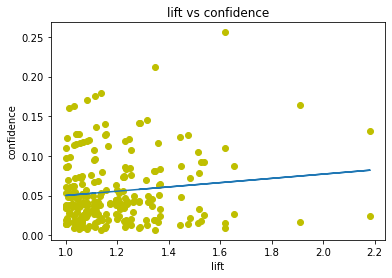

In [29]:
plot_metrics_relationship(fp_growth_rule_lift, col1='lift', col2='confidence')

In [30]:
fp_growth_rule = compute_association_rule(fpgrowth_matrix, metric="confidence", min_thresh=0.2)
fp_growth_rule.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(sausage, yogurt)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,0.000563,1.131541
1,"(rolls/buns, sausage)",(whole milk),0.005347,0.157923,0.001136,0.212500,1.345594,0.000292,1.069304


## Apriori 

In [32]:
apriori_matrix, apriori_exec_time = perform_rule_calculation(te_matrix, rule_type="apriori")
print("Apriori Execution took: {} seconds".format(apriori_exec_time))
apriori_matrix.head()

Computed Apriori!
Apriori Execution took: 6.60603404045105 seconds


,support,itemsets,number_of_items
0,0.004010,(Instant food products),1
1,0.021386,(UHT-milk),1
2,0.001470,(abrasive cleaner),1
3,0.001938,(artif. sweetener),1
4,0.008087,(baking powder),1


### Lift

In [34]:
apriori_rule_lift = compute_association_rule(apriori_matrix)
apriori_rule_lift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(tropical fruit),(UHT-milk),0.067767,0.021386,0.001537,0.022682,1.060617,8.785064e-05,1.001326
1,(UHT-milk),(tropical fruit),0.021386,0.067767,0.001537,0.071875,1.060617,8.785064e-05,1.004426
2,(brown bread),(beef),0.037626,0.033950,0.001537,0.040853,1.203301,2.597018e-04,1.007196
3,(beef),(brown bread),0.033950,0.037626,0.001537,0.045276,1.203301,2.597018e-04,1.008012
4,(citrus fruit),(beef),0.053131,0.033950,0.001804,0.033962,1.000349,6.297697e-07,1.000012


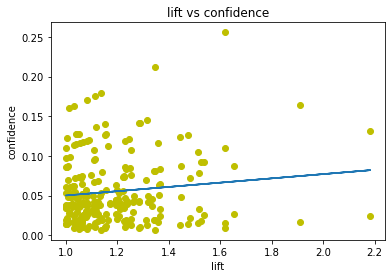

In [35]:
plot_metrics_relationship(apriori_rule_lift, col1='lift', col2='confidence')

### Confidence

In [36]:
aprio_rule_confidence = compute_association_rule(apriori_matrix, metric='confidence', min_thresh=0.2)
aprio_rule_confidence.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(rolls/buns, sausage)",(whole milk),0.005347,0.157923,0.001136,0.212500,1.345594,0.000292,1.069304
1,"(sausage, yogurt)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,0.000563,1.131541
